-----
Import stage

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib import colors

In [2]:
labels_map = {i: cc for i, cc in enumerate('rgy')}

------
Prepare random data here

In [3]:
centers = tf.random.uniform(
    # shape: K, vector dim, 1 for column vector
    shape=(3, 2),
    minval=1.0,
    maxval=7.0,
    dtype=tf.float32,
    seed=7000)
data = tf.concat([
    tf.random.normal((100, 2), 0.0, 0.5) + tf.constant([1, 3], tf.float32),
    tf.random.normal((100, 2), 0.0, 0.5) + tf.constant([4, 2], tf.float32),
    tf.random.normal((100, 2), 0.0, 0.5) + tf.constant([7, 8], tf.float32),
], axis=0)

In [4]:
x, y = data[:, 0], data[:, 1]

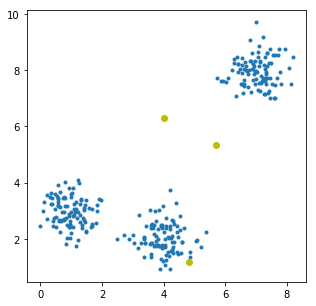

In [5]:
plt.figure(figsize=(5, 5))
plt.plot(x, y, '.')
_ = plt.plot(centers[:, 0], centers[:, 1], 'yo')

In [6]:
print(data.shape)
print(centers.shape)

(300, 2)
(3, 2)


-----
L2-Norm of each point, corresponds to their centroid:

$$ d^2_i = \operatorname*{arg\,min}_k ||x_i-c_k||^2 $$

K-Means loss is mean of corresponds norms:

$$ L = \frac{1}{n} \sum_{i=0}^n{d^2_i} $$

Calculate new centroid based on assigned groups:
$$ c_k = \frac{1}{|S_n|} \sum_{x_i \in S_k}^n{x_i}$$

In [17]:
data_shape = tf.shape(data, tf.int64)
data_count = data_shape[0]
data_dim = data_shape[1]

In [18]:
distances = tf.norm(data[:, tf.newaxis, ...] - centers, axis=-1) ** 2
print('distances.shape =', distances.shape)

indices = tf.argmin(distances, axis=1)  # Assigned indice for each data point
gather_indices = tf.concat(
    [
        tf.expand_dims(tf.range(data_count, dtype=tf.int64), -1),
        tf.expand_dims(indices, -1)
    ], axis=-1)
corr_norms = tf.gather_nd(distances, gather_indices)

kmeans_losses = tf.reduce_mean(corr_norms)
print(kmeans_losses)

distances.shape = (300, 3)
tf.Tensor(9.479459, shape=(), dtype=float32)


-----
Calcuate new centroids based on new indices hint:
- Assgin each data point to a new spare tensor, with first dim corrs to each corr centroid indice
- Calculate reduce mean on first dimmension
- The result should be new centroids

In [19]:
count = \
tf.transpose(
    tf.reduce_sum(
        tf.one_hot(indices, 3), 0, True
    )
) # indice count

In [38]:
scatter_shape = tf.concat([
    [data_count],
    [3],
    [data_dim]
], 0)

In [39]:
nc = \
tf.reduce_sum(
    tf.scatter_nd(
        gather_indices, 
        data, 
        scatter_shape
    ),  # Scatter data into spare tensor
    axis=0
)

In [40]:
print('        indices.shape =', indices.shape)
print(' gather_indices.shape =', gather_indices.shape)
print('           data.shape =', data.shape)
print('          count.shape =', count.shape)
print('             nc.shape =', nc.shape)

        indices.shape = (300,)
 gather_indices.shape = (300, 2)
           data.shape = (300, 2)
          count.shape = (3, 1)
             nc.shape = (3, 2)


In [62]:
new_centers = nc/count
new_distances = tf.norm(data[:, tf.newaxis, ...] - new_centers, axis=-1) ** 2
new_indices = tf.argmin(new_distances, axis=1)  # Assigned indice for each data point

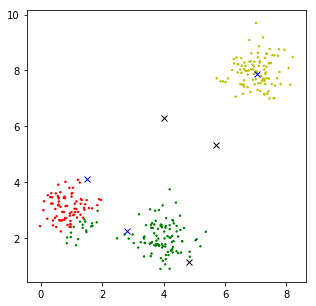

In [63]:
plt.figure(figsize=(5, 5))
# plt.scatter(x, y, s=2, c=[labels_map[i.numpy().astype(int)] for i in indices])
plt.plot(centers[:, 0], centers[:, 1], 'xk')
plt.plot(new_centers[:, 0], new_centers[:, 1], 'xb')
plt.scatter(x, y, s=2, c=[labels_map[i.numpy().astype(int)] for i in new_indices])

plt.show()